Example of running basic Bayesian inference (non-hierachical) with the code:

We consider a single mass, limepy model with $(g,\Phi_0,\log_{10}M,r_h)=(2,5,5,3)$. We samples 1000 points from the DF in Cartesian coordinates and use the perfect/ideal data to infer the four structural parameters.

In [1]:
#just generate some random seeds
import numpy as np
param_array_m = np.stack(np.meshgrid([1.6,1.2,2.0],[3, 5, 8],[5, 6],[3,9]), -1).reshape(-1, 4)
param_array = np.copy(param_array_m)
param_array[:,0]=param_array_m[:,1]
param_array[:,1]=param_array_m[:,0]
param_array=param_array[:32]

np.random.seed(1)
random_array = np.random.randint(low=0, high=10000, size=(1000,2))

We first simulate the perfect limepy data, and then perform Bayesian inference

In [2]:
#this is the basic_bayesian_inference model, using cartesian coordinates with perfect data
from Bayesian_Inference import Bayesian_limepy_sampling
from limepy import limepy,sample

def simulate_fit_perfect_data(whether_interpolate,index,seed_limepy,ip,Np=1000,ndraws=2000,nburns=2000,chains=4,target_accept=0.8):
    #generated simulated data
    W0true, gtrue,log10Mtrue,rhtrue = ip
    k = limepy(W0true, gtrue, M=10**log10Mtrue, rh=rhtrue)
    ic = sample(k,N=Np,seed=seed_limepy)
    r = np.sqrt((ic.x)**2+(ic.y)**2+(ic.z)**2)
    v = np.sqrt((ic.vx)**2+(ic.vy)**2+(ic.vz)**2)
    
    xhhh = np.concatenate([np.array(ip[:3]),np.log10(np.array([ip[3]]))])
    #create sampling class
    B_S = Bayesian_limepy_sampling(r,v,test_param=xhhh,whether_interpolate=whether_interpolate)
    #inference
    idata = B_S.sampling(ndraws=ndraws,nburns=nburns,chains=chains,target_accept=target_accept)
    return idata
   
index = 200
seed_error, seed_limepy = random_array[index,0],random_array[index,1] 
#W，g, log10M, rh
ip = list(param_array[index//10])
idata_interp = simulate_fit_perfect_data(True,index,seed_limepy,ip,ndraws=2000,nburns=2000,chains=4)
#high Phi local minimum is somehow common in this case

-15448.06
[ -9.963165  -30.505371  -68.37849    -3.6573865]


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Phi0, g, log10M, log10rh]
INFO:pymc:NUTS: [Phi0, g, log10M, log10rh]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 110 seconds.
INFO:pymc:Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 110 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


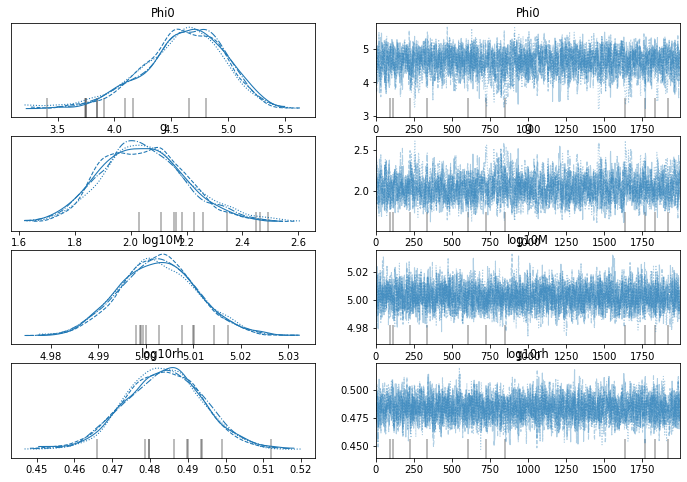

In [4]:
import arviz as az
_ = az.plot_trace(idata_interp,var_names=["Phi0", "g", "log10M", "log10rh"])

In [6]:
names = ["log10M","Phi0","g","log10rh"]
labels =  ["log_{10}M","\Phi_0","g","log_{10}r_h"]
from getdist import plots, MCSamples

df_interp = idata_interp.to_dataframe()
df_np_interp = df_interp.to_numpy()
samples_interp = MCSamples(samples=(df_np_interp[:,2:6]).astype('float32'),names = names, labels = labels,label='Second set')

Removed no burn in


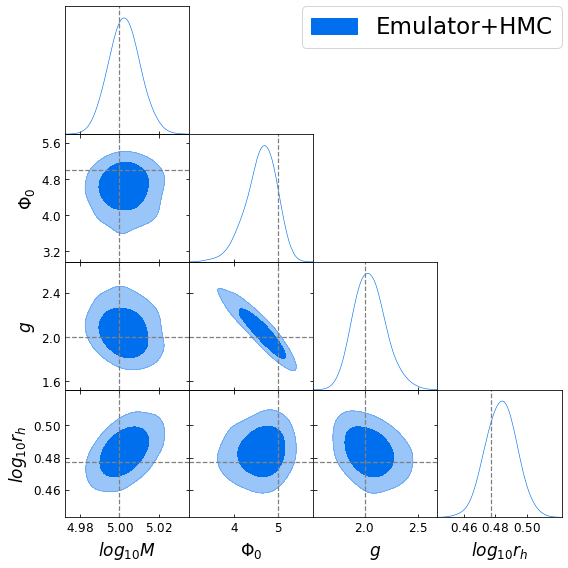

In [7]:
m = plots.GetDistPlotSettings()
m.legend_fontsize = 26
m.axes_labelsize = 20
#m.line_labels =False
m.axis_marker_lw = 1.25
m.axes_fontsize = 15

g = plots.get_subplot_plotter(settings=m)
g.triangle_plot([samples_interp],filled=True,\
                markers={"g": ip[1], "Phi0": ip[0], "log10M": ip[2], "log10rh": np.log10(ip[3])},\
               legend_labels=['Emulator+HMC'],legend_loc='upper right')